<p>&nbsp;</p>

### **Introduction**

<p>&nbsp;</p>

<font size = "3">

In this report, I will perform text mining on a sample of restaurant reviews. The goal is to build a model that can predict whether a review is fake / real and whether the sentiment of a review is positive / negative. I will be training a multinomial naive bayes model and using grid search for hyper parameter tuning. I then will be reporting out the most important words that model learned in the process.

<p>&nbsp;</p>

#### **Import Libraries**

<p>&nbsp;</p>

<font size = "3">

I will start off by loading some standard packages. Additional packages may be loaded later on as needed.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import nltk
import re

<p>&nbsp;</p>

#### **Import Data**

<p>&nbsp;</p>

<font size = "3">

In the following code, I will use the arff2pandas package to read in the .arff file and store in a pandas dataframe. Make sure that the .arff file is located in the current working directory otherwise modify the file pathway in the open() function accordingly before running the code.

In [55]:
# Import data

# Use the arff2pandas library to read the .arff file
from arff2pandas import a2p

# Read the .arff file and store it in a variable called reviews
with open("deception_data_converted_arff.arff") as data_file:
    reviews_df = a2p.load(data_file)

<p>&nbsp;</p>

#### **Initial Data Check**

<p>&nbsp;</p>

<font size = "3">

Before moving on, at this point it is a good idea to take a quick look at the data, make sure that it was loaded properly, evaluate the structure, check for missing values, etc.

In [56]:
# Show the structure of the data
print("Number of Rows = ", len(reviews_df))           # Number of rows
print("Number of Cols = ", len(reviews_df.columns))   # Number of columns

Number of Rows =  92
Number of Cols =  3


In [57]:
# Show the top 5 rows of the data
reviews_df.head()

,"lie@{fake,true}","sentiment@{negative,positive}",review@STRING
0,fake,negative,"Mike's Pizza High Point, NY Service was very s..."
1,fake,negative,i really like this buffet restaurant in Marsha...
2,fake,negative,"After I went shopping with some of my friend, ..."
3,fake,negative,Olive Oil Garden was very disappointing. I exp...
4,fake,negative,The Seven Heaven restaurant was never known fo...


In [58]:
# Show the bottom 5 rows of the data
reviews_df.tail()

,"lie@{fake,true}","sentiment@{negative,positive}",review@STRING
87,true,positive,Pastablities is a locally owned restaurant in ...
88,true,positive,I like the Pizza at Dominoes for their special...
89,true,positive,It was a really amazing Japanese restaurant. T...
90,true,positive,How do I even pick a best experience at Joe's ...
91,true,positive,My sister and I ate at this restaurant called ...


In [59]:
# Change the column headers to something friendlier
reviews_df.columns = ["is_fake", "sentiment", "reviews"]

In [62]:
# What are the value counts for the two output columns
print(reviews_df.is_fake.value_counts(), "\n")
print(reviews_df.sentiment.value_counts())

true    46
fake    46
Name: is_fake, dtype: int64 

positive    46
negative    46
Name: sentiment, dtype: int64


In [67]:
# Look at the data types, why are strings int64s?
reviews_df.dtypes

is_fake      object
sentiment    object
reviews      object
dtype: object

In [72]:
# Change the data types to something not ambiguous
reviews_df["is_fake"] = reviews_df["is_fake"].astype("string")
reviews_df["sentiment"] = reviews_df["sentiment"].astype("string")
reviews_df["reviews"] = reviews_df["reviews"].astype("string")

In [73]:
# Check to make sure the data type conversion was successful
reviews_df.dtypes

is_fake      string
sentiment    string
reviews      string
dtype: object

In [74]:
# Show the full text of the first 5 reviews
for review in reviews_df["reviews"][0:5]: print(review, "\n")

Mike's Pizza High Point, NY Service was very slow and the quality was low. You would think they would know at least how to make good pizza, not. Stick to pre-made dishes like stuffed pasta or a salad. You should consider dining else where. 

i really like this buffet restaurant in Marshall street. they have a lot of selection of american, japanese, and chinese dishes. we also got a free drink and free refill. there are also different kinds of dessert. the staff is very friendly. it is also quite cheap compared with the other restaurant in syracuse area. i will definitely coming back here. 

After I went shopping with some of my friend, we went to DODO restaurant for dinner. I found worm in one of the dishes . 

Olive Oil Garden was very disappointing. I expect good food and good service (at least!!) when I go out to eat. The meal was cold when we got it, and the waitor had no manners whatsoever. Don't go to the Olive Oil Garden.  

The Seven Heaven restaurant was never known for a supe

In [75]:
# Check for missing values
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   is_fake    92 non-null     string
 1   sentiment  92 non-null     string
 2   reviews    92 non-null     string
dtypes: string(3)
memory usage: 2.3 KB


In [76]:
# Describe the data
reviews_df.describe()

,is_fake,sentiment,reviews
count,92,92,92
unique,2,2,91
top,true,positive,
freq,46,46,2


<p>&nbsp;</p>

<font size = "3">

The dataset is fairly small - only 92 samples in total. Both the of the classification labels are evenly distributed with 46 samples for each label. At first, it does not appear that there are any missing values. But after a closer look, the number of unique values in the review columns is only 91 / 92 which tells me that there is a duplicate value. There should not be any duplicate vlaues because the reviews should all be unique. In the following code, I discover that the duplicate value is actually a blank character string, so I will remove those 2 records from the data.

In [77]:
# Define a function to check if a count is > 1
def check_count(count):
    if count > 1: return True

# Store a dictionary of each review and its count
counts = dict(reviews_df["reviews"].value_counts())

# Extract the review that has a count > 1
for key, value in counts.items():
    if value > 1: print(key, len(key))

 0


In [78]:
# Remove the reviews that do not have any text
reviews_df = reviews_df[(reviews_df["reviews"] != "")]

# Print the shape of the new dataframe after removing the blanks
print("Shape of df after removing blank reviews = ", reviews_df.shape)

Shape of df after removing blank reviews =  (90, 3)


<p>&nbsp;</p>

#### **Data Exploration**

<p>&nbsp;</p>

<font size = "3">

In this section, I will explore some questions related to the reviews such as:
- What is the distribution of the length of the reviews?
- What about broken out by fake / true review, positive / negative review, etc.?
- Generate word clouds for reviews

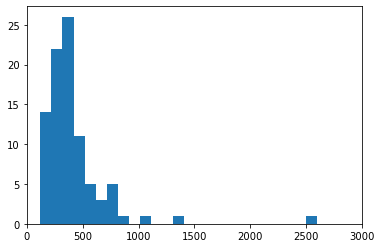

In [12]:
# Show a histogram of the length of all reviews
from matplotlib import pyplot as plt
review_lengths = [len(text) for text in reviews_df["reviews"]]
plt.hist(review_lengths, bins = 25)
plt.xlim(xmin = 0, xmax = 3000)
plt.show()

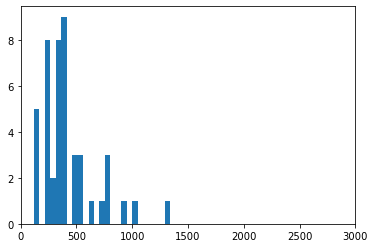

In [13]:
# Show a histogram of the length of fake reviews
from matplotlib import pyplot as plt
lengths = [len(text) for text in reviews_df[reviews_df["is_fake"] == "fake"]["reviews"]]
plt.hist(lengths, bins = 25)
plt.xlim(xmin = 0, xmax = 3000)
plt.show()

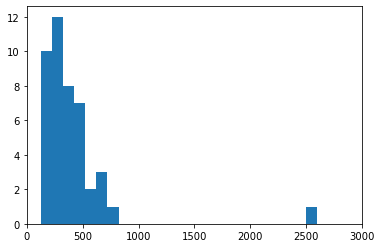

In [14]:
# Show a histogram of the length of true reviews
from matplotlib import pyplot as plt
lengths = [len(text) for text in reviews_df[reviews_df["is_fake"] == "true"]["reviews"]]
plt.hist(lengths, bins = 25)
plt.xlim(xmin = 0, xmax = 3000)
plt.show()

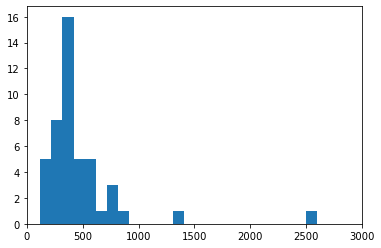

In [15]:
# Show a histogram of the length of negative reviews
from matplotlib import pyplot as plt
lengths = [len(text) for text in reviews_df[reviews_df["sentiment"] == "negative"]["reviews"]]
plt.hist(lengths, bins = 25)
plt.xlim(xmin = 0, xmax = 3000)
plt.show()

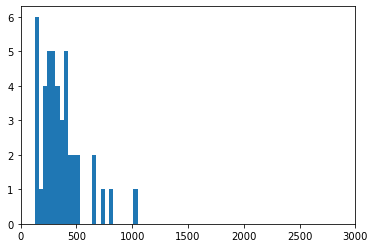

In [16]:
# Show a histogram of the length of negative reviews
from matplotlib import pyplot as plt
lengths = [len(text) for text in reviews_df[reviews_df["sentiment"] == "positive"]["reviews"]]
plt.hist(lengths, bins = 25)
plt.xlim(xmin = 0, xmax = 3000)
plt.show()

<p>&nbsp;</p>

#### **Multinomial Naive Bayes**

<p>&nbsp;</p>

<font size = "3">

I will build a pipeline that conducts the vectorization. I will be trying out different ways to vectorize to compare the performances. In the pipeline I will also train a multinomial naive bayes model. I will be using a grid search for hyper parameter tuning both on the vectorization and multinomial naive bayes model. I will loop through a 5 fold cross validation, apply the pipeline, and train and test a multinomial naive bayes model in each instance, and print out the resulting accuracy score. I will do separately for both predicting fake reviews and predicting the sentiment of the reviews.

In [19]:
# Import packages from scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# Set up the vectorization pipeline
tfidf_pip = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer())
])

In [21]:
# Set up the naive bayes pipeline
mnb_pipeline = Pipeline([
    ('tfidf_pip', tfidf_pip),
    ('mnb', MultinomialNB())
])

In [22]:
# Set up the grid search params
grid_params = {
  'mnb__alpha': np.linspace(0.5, 1.5, 6),
  'mnb__fit_prior': [True, False],
  'tfidf_pip__tfidf_vectorizer__use_idf': [True, False],
  'tfidf_pip__tfidf_vectorizer__max_df': np.linspace(0.1, 1, 10),
  'tfidf_pip__tfidf_vectorizer__binary': [True, False],
  'tfidf_pip__tfidf_vectorizer__norm': [None, 'l1', 'l2'], 
}

In [145]:
# Initiate the split object
split = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Initiate a counter
run_counter = 0

# Initiate lists to store the results in
run_number = []
train_accuracy = []
test_accuracy = []
parameters = []

# Iterate through each fold and conduct the process
for train_index, test_index in split.split(reviews_df, reviews_df["reviews"]):

    # Seperate out the train and test sets
    train_data = reviews_df.iloc[train_index, :]
    test_data = reviews_df.iloc[test_index, :]
    
    # Separate out the predictors
    X_train = train_data["reviews"]
    X_test = test_data["reviews"]
    
    # Seperate out the class labels
    y_train = train_data["is_fake"].copy()
    y_test = test_data["is_fake"].copy()

    # Train model and and make predictions
    clf = GridSearchCV(mnb_pipeline, grid_params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    # Store the information from the run
    train_score = clf.best_score_
    test_score = accuracy_score(y_test, predictions)
    best_params = clf.best_params_

    # Append this information to the cumulative lists
    run_number.append(run_counter + 1)
    train_accuracy.append(train_score)
    test_accuracy.append(test_score)
    parameters.append(best_params)

    # Update the counter after each iteration
    run_counter += 1

    # Create a dummy vectorizer just to get the feature names
    dummy_vectorizer = TfidfVectorizer()
    dummy_vect_data = dummy_vectorizer.fit_transform(X_train)

    # Get the fake and real log probability arrays and sort ascending
    neg_class_prob_sorted = clf.best_estimator_.named_steps["mnb"].feature_log_prob_[0].argsort()[::-1]   # fake review log probabilities
    pos_class_prob_sorted = clf.best_estimator_.named_steps["mnb"].feature_log_prob_[1].argsort()[::-1]   # real review log probaiblities

    # Print out the results
    print("Run ", run_counter, " Completed", "\n")
    print("Train Score: ", train_score)
    print("Test Score ", test_score, "\n")
    print("Best Params: ", best_params, "\n")

    # Print out the top 10 most predictive features for fake reviews
    print("Top 10 Most Predictive Features for Fake Reviews")
    print(np.take(dummy_vectorizer.get_feature_names(), neg_class_prob_sorted[:10]), "\n")

    # Print out the top 10 most predictive features for real reviews
    print("Top 10 Most Predictive Features for Real Reviews")
    print(np.take(dummy_vectorizer.get_feature_names(), pos_class_prob_sorted[:10]), "\n")

Run  1  Completed 

Train Score:  0.680952380952381
Test Score  0.5555555555555556 

Best Params:  {'mnb__alpha': 1.1, 'mnb__fit_prior': True, 'tfidf_pip__tfidf_vectorizer__binary': True, 'tfidf_pip__tfidf_vectorizer__max_df': 0.4, 'tfidf_pip__tfidf_vectorizer__norm': 'l2', 'tfidf_pip__tfidf_vectorizer__use_idf': True} 

Top 10 Most Predictive Features for Fake Reviews
['watched' 'bento' 'group' 'least' 'want' 'waitresses' 'seem' 'terrific'
 'assistant' 'pet'] 

Top 10 Most Predictive Features for Real Reviews
['hasn' 'going' 'used' 'pet' 'nightmare' 'waitresses' 'weird' 'eventually'
 'beef' 'slice'] 

Run  2  Completed 

Train Score:  0.6676190476190477
Test Score  0.3333333333333333 

Best Params:  {'mnb__alpha': 1.5, 'mnb__fit_prior': False, 'tfidf_pip__tfidf_vectorizer__binary': False, 'tfidf_pip__tfidf_vectorizer__max_df': 1.0, 'tfidf_pip__tfidf_vectorizer__norm': 'l2', 'tfidf_pip__tfidf_vectorizer__use_idf': False} 

Top 10 Most Predictive Features for Fake Reviews
['the' 'and' '

In [146]:
# Initiate the split object
split = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Initiate a counter
run_counter = 0

# Initiate lists to store the results in
run_number = []
train_accuracy = []
test_accuracy = []
parameters = []

# Iterate through each fold and conduct the process
for train_index, test_index in split.split(reviews_df, reviews_df["reviews"]):

    # Seperate out the train and test sets
    train_data = reviews_df.iloc[train_index, :]
    test_data = reviews_df.iloc[test_index, :]
    
    # Separate out the predictors
    X_train = train_data["reviews"]
    X_test = test_data["reviews"]
    
    # Seperate out the class labels
    y_train = train_data["sentiment"].copy()
    y_test = test_data["sentiment"].copy()

    # Train model and and make predictions
    clf = GridSearchCV(mnb_pipeline, grid_params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    # Store the information from the run
    train_score = clf.best_score_
    test_score = accuracy_score(y_test, predictions)
    best_params = clf.best_params_

    # Append this information to the cumulative lists
    run_number.append(run_counter + 1)
    train_accuracy.append(train_score)
    test_accuracy.append(test_score)
    parameters.append(best_params)

    # Update the counter after each iteration
    run_counter += 1

    # Create a dummy vectorizer just to get the feature names
    dummy_vectorizer = TfidfVectorizer()
    dummy_vect_data = dummy_vectorizer.fit_transform(X_train)

    # Get the negative and positive log probability arrays and sort ascending
    neg_class_prob_sorted = clf.best_estimator_.named_steps["mnb"].feature_log_prob_[0].argsort()[::-1]   # negative log probabilities
    pos_class_prob_sorted = clf.best_estimator_.named_steps["mnb"].feature_log_prob_[1].argsort()[::-1]   # positive log probabilities

    # Print out the results
    print("Run ", run_counter, " Completed")
    print("Train Score: ", train_score)
    print("Test Score ", test_score)
    print("Best Params: ", best_params, "\n")

    # Print out the top 10 most predictive features for fake reviews
    print("Top 10 Most Predictive Features for Negative Reviews")
    print(np.take(dummy_vectorizer.get_feature_names(), neg_class_prob_sorted[:10]), "\n")

    # Print out the top 10 most predictive features for real reviews
    print("Top 10 Most Predictive Features for Positive Reviews")
    print(np.take(dummy_vectorizer.get_feature_names(), pos_class_prob_sorted[:10]), "\n")

Run  1  Completed
Train Score:  0.9028571428571428
Test Score  0.9444444444444444
Best Params:  {'mnb__alpha': 0.5, 'mnb__fit_prior': True, 'tfidf_pip__tfidf_vectorizer__binary': False, 'tfidf_pip__tfidf_vectorizer__max_df': 0.8, 'tfidf_pip__tfidf_vectorizer__norm': None, 'tfidf_pip__tfidf_vectorizer__use_idf': False} 

Top 10 Most Predictive Features for Negative Reviews
['time' 'warm' 'obviously' 'isn' 'watched' 'iron' 'music' 'food' 'imagine'
 'than'] 

Top 10 Most Predictive Features for Positive Reviews
['iron' 'time' 'isn' 'obviously' 'warm' 'winning' 'rest' 'followed'
 'imagine' 'music'] 

Run  2  Completed
Train Score:  0.9304761904761906
Test Score  0.7777777777777778
Best Params:  {'mnb__alpha': 1.1, 'mnb__fit_prior': False, 'tfidf_pip__tfidf_vectorizer__binary': False, 'tfidf_pip__tfidf_vectorizer__max_df': 0.30000000000000004, 'tfidf_pip__tfidf_vectorizer__norm': None, 'tfidf_pip__tfidf_vectorizer__use_idf': False} 

Top 10 Most Predictive Features for Negative Reviews
['wa

<p>&nbsp;</p>

### **Conclusion**

<p>&nbsp;</p>

<font size = "3">

When it came to predicting whether or not the review was fake, the model did not do a very good job. There was more variability in the accuracy scores and most of the cross validations were overtrained. In addition, the words that the model thought were important for predicting whether a review was fake or not did not seem intuitive to me. I am not surprised that htis is the case because it can be difficult enough for a human to determine if a review is fake or not. There is too much ambiguity in determining whether a review is fake or not.

On the other hand, predicting sentiment seems much more straight forward and objective. It is typically pretty clear when looking at a review to tell whether it is positive or negative based on certain words that are being used. The model was able to pick up on this pretty accurately with less overtraining but still likely some overtraining.

I think that it would be helpful to have more data. The small sample that is provided can only get so far. I would have been interested to do a "leave one out" cross validation, but this would have been too labor intensive. It already took my machine about 10 minutes to run the 5 fold cross validation, granted I used a grid search for hyperparameter tuning which of course adds some time to the model training.